In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier, plot_importance

# Загрузка данных

In [2]:
ds = pd.read_csv('rosbank_train.csv')
print(ds.shape)
ds.head()

(490513, 10)


,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


# EDA

In [3]:
ds.isnull().sum()

PERIOD             0
cl_id              0
MCC                0
channel_type    2910
currency           0
TRDATETIME         0
amount             0
trx_category       0
target_flag        0
target_sum         0
dtype: int64

In [4]:
ds['channel_type'].value_counts()

type1    299247
type2    175013
type5      5587
type4      4476
type3      3280
Name: channel_type, dtype: int64

Запишем пропущенные значения как type0

In [5]:
ds['channel_type'] = ds['channel_type'].fillna('type0')

## Знакомство с признаками
Попробуем разобраться, какие признаки отражают столбцы

Список всех столбцов

In [6]:
ds.columns

Index(['PERIOD', 'cl_id', 'MCC', 'channel_type', 'currency', 'TRDATETIME',
       'amount', 'trx_category', 'target_flag', 'target_sum'],
      dtype='object')

### PERIOD

In [7]:
ds['PERIOD'].dtype

dtype('O')

In [8]:
ds['PERIOD'].value_counts()

01/07/2017    55757
01/06/2017    54082
01/05/2017    46492
01/08/2017    46245
01/12/2016    45788
01/01/2017    44254
01/04/2017    42952
01/02/2017    37309
01/03/2017    35068
01/09/2017    27796
01/11/2016    20923
01/10/2017    11370
01/11/2017     5368
01/12/2017     5041
01/10/2016     3694
01/01/2018     3397
01/02/2018     2765
01/03/2018     2175
01/04/2018       37
Name: PERIOD, dtype: int64

Период - первый день месяца в формате строки. Переведём его в формат даты

In [9]:
ds['PERIOD_dt'] = pd.to_datetime(ds['PERIOD'], format='%d/%m/%Y')

PERIOD - это месяц совершения чего?

/home/egor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


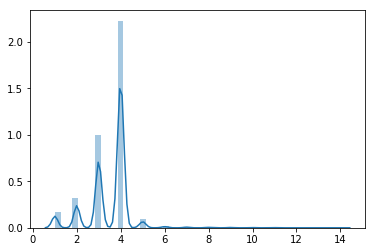

In [10]:
sns.distplot(ds.groupby('cl_id').agg({'PERIOD':'nunique'}))

Для одного клиента могут быть несколько значений PERIOD, т.е. это не месяц привлечения клиента

In [11]:
ds[['TRDATETIME','PERIOD']].head()

,TRDATETIME,PERIOD
0,21OCT17:00:00:00,01/10/2017
1,12OCT17:12:24:07,01/10/2017
2,05DEC17:00:00:00,01/12/2017
3,21OCT17:00:00:00,01/10/2017
4,24OCT17:13:14:24,01/10/2017


Месяц PERIOD совпадает с месяцем TRDATETIME. Видимо это месяц совершения транзакции

### cl_id

cl_id - это, очевидно, id клиента

Посмотрим, сколько у нас клиентов и как сколько транзакций совершил каждый клиент

In [12]:
f"Всего {ds['cl_id'].nunique()} клиентов"

'Всего 5000 клиентов'

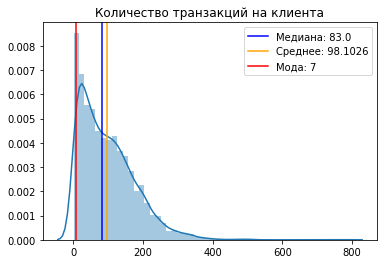

In [13]:
vc = ds['cl_id'].value_counts()
sns.distplot(vc.values)
plt.title('Количество транзакций на клиента')
plt.axvline(vc.median(), label=f'Медиана: {vc.median()}', color='blue')
plt.axvline(vc.mean(), label=f'Среднее: {vc.mean()}', color='orange')
plt.axvline(vc.mode().values, label=f'Мода: {vc.mode().values[0]}', color='red')
plt.legend()
plt.show()

Много клиентов совершили всего 7 транзакций, однако в основном на клиента приходится по 100 транзакций, что позволяет найти какие-то статистические закономерности

### MCC

MCC код (англ. Merchant Category Code — буквально «код категории продавца») — представляет собой 4-значный номер, классифицирующий вид деятельности торговой точки в операции оплаты по банковским картам в торгово-сервисном предприятии при электронной передаче информации в рамках транзакции за предоставляемые товары или услуги.

В репозитории https://github.com/lightforever/rosbank есть csv файл по MCC кодам

In [14]:
mcc_ds = pd.read_csv('rosbank/mcc_codes.csv')
print(mcc_ds.shape)
mcc_ds.head()

(1018, 3)


,MCC,MCC_desc,MCC_group
0,742,Ветеринарные услуги,Контрактные услуги
1,763,Сельскохозяйственные кооперативы,Контрактные услуги
2,780,Ландшафтные и садоводческие магазины,Контрактные услуги
3,1520,Генеральные подрядчики – жилищное и торговое с...,Контрактные услуги
4,1711,Генеральные подрядчики по вентиляции теплоснаб...,Контрактные услуги


In [15]:
mcc_ds.loc[mcc_ds['MCC_desc'].isnull(), 'MCC_desc'] = mcc_ds.loc[mcc_ds['MCC_desc'].isnull(), 'MCC_group']

In [16]:
ds = pd.merge(ds, mcc_ds, on='MCC')

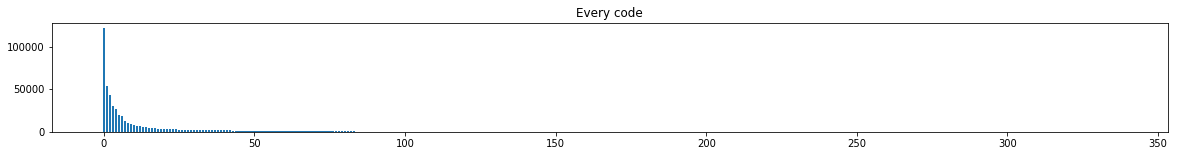

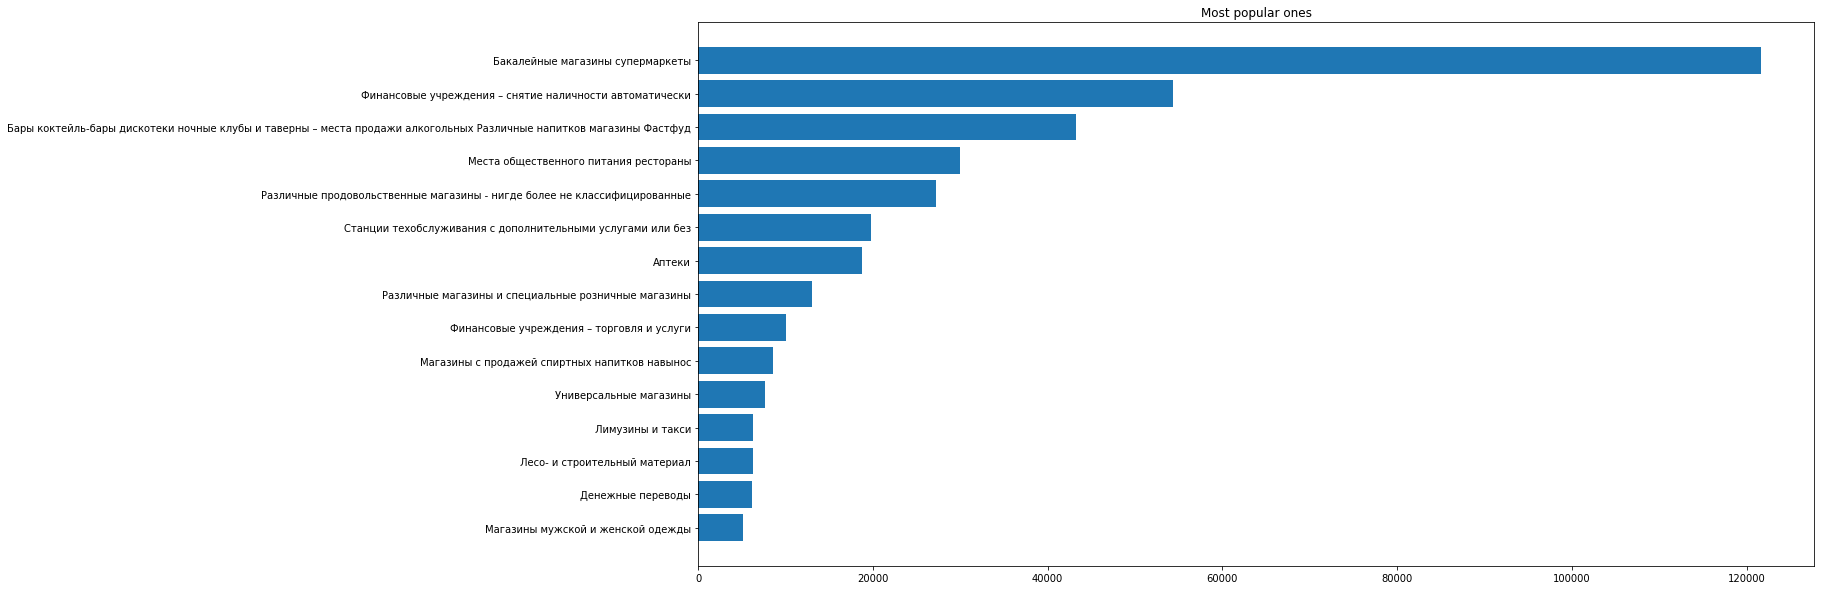

In [17]:
plt.figure(figsize=(20,2))
s = ds['MCC_desc'].value_counts()
#sns.distplot(s.values)
plt.bar(range(len(s)), s.values)
plt.title('Every code')
plt.show()

plt.figure(figsize=(20,10))
s = s[s>s.sum()*0.01].sort_values(ascending=True)
plt.barh(range(len(s)), s.values)
plt.yticks(range(len(s)), s.index, rotation=0)#, fontsize=32)
plt.title('Most popular ones')
plt.show()

Оставим только наиболее популярные MCC коды

In [18]:
ds['MCC_grouped'] = ds['MCC_desc'].apply(lambda x: x if x in s.index else 'other')

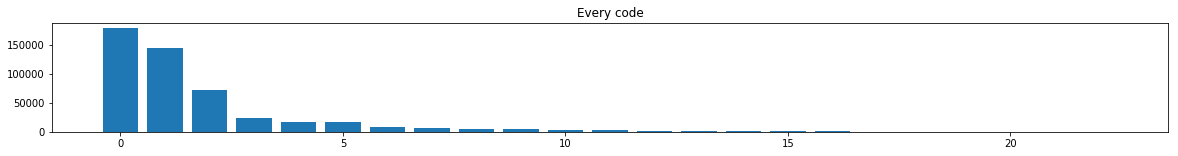

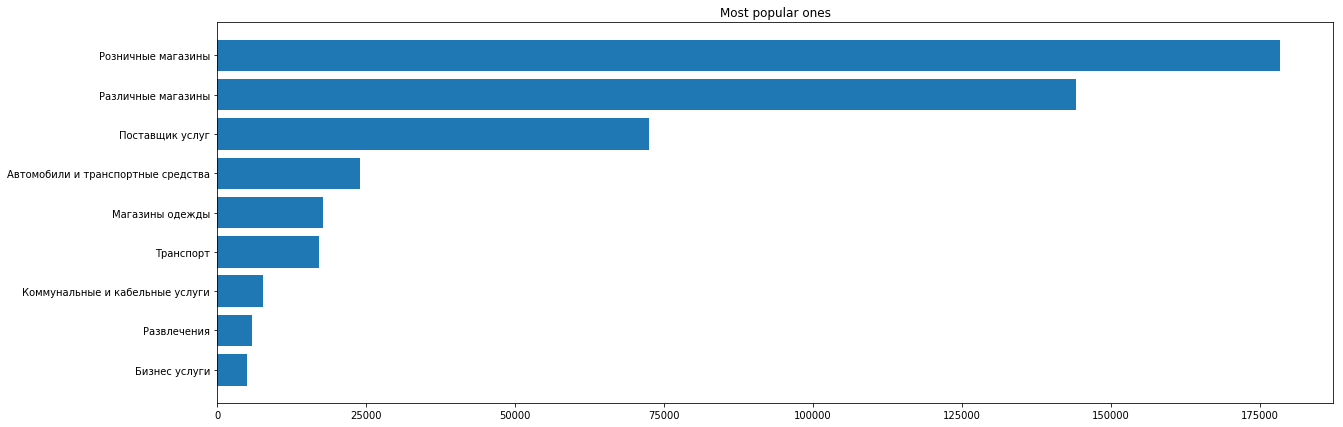

In [19]:
plt.figure(figsize=(20,2))
s = ds['MCC_group'].value_counts()
#sns.distplot(s.values)
plt.bar(range(len(s)), s.values)
plt.title('Every code')
plt.show()

plt.figure(figsize=(20,7))
s = s[s>s.sum()*0.01].sort_values(ascending=True)
plt.barh(range(len(s)), s.values)
plt.yticks(range(len(s)), s.index, rotation=0, )#fontsize=32)
plt.title('Most popular ones')
plt.show()

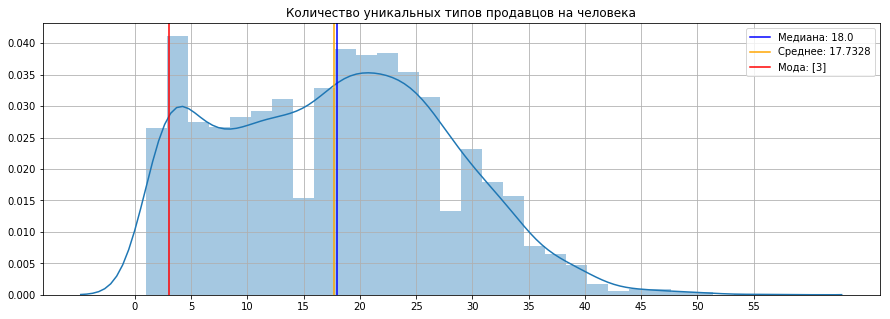

In [20]:
plt.figure(figsize=(15,5))
s = ds.groupby('cl_id').agg({'MCC':'nunique'})
sns.distplot(s)
plt.axvline(s.median().values, label=f'Медиана: {s.median().values[0]}', color='blue')
plt.axvline(s.mean().values, label=f'Среднее: {s.mean().values[0]}', color='orange')
plt.axvline(s.mode().values, label=f'Мода: {s.mode().values[0]}', color='red')
plt.legend()
plt.title('Количество уникальных типов продавцов на человека')
plt.grid()
plt.xticks(range(0,60,5), range(0,60,5))
plt.show()

Всех клиентов можно разделить на 2 группы: активные (>8 уникальных типов транзакций) и неактивные (<8)

In [21]:
s = ds.groupby('cl_id').agg({'MCC':'nunique'})
s = s[s>=8].dropna().index
ds['is_active_client'] = ds['cl_id'].isin(s)

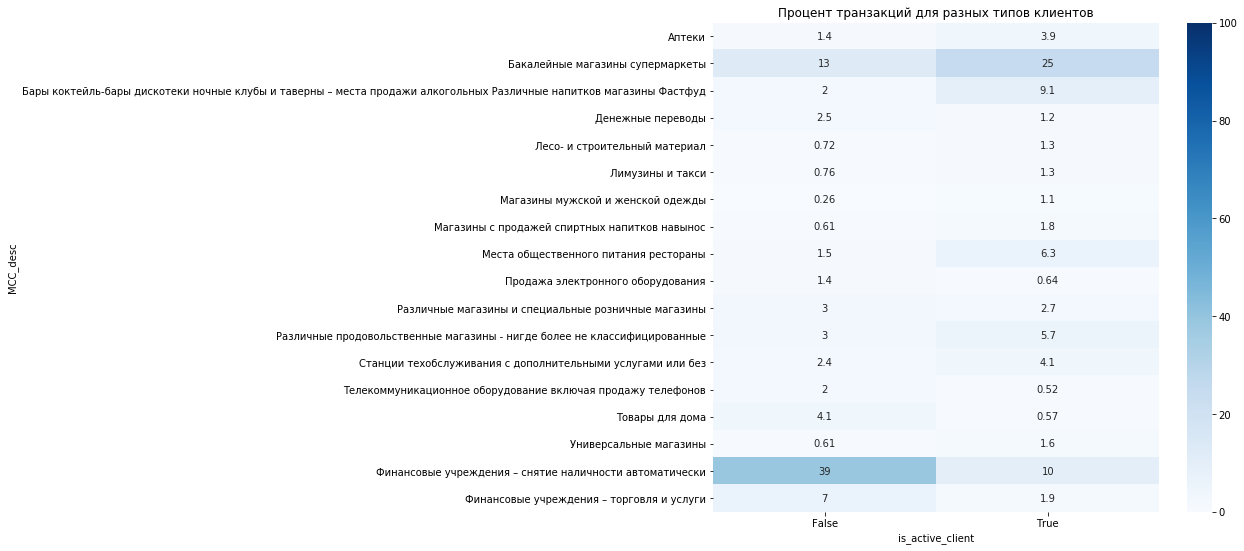

In [22]:
plt.figure(figsize=(10,9))
s = ds.pivot_table(index='MCC_desc', columns='is_active_client', values='TRDATETIME', aggfunc='count', fill_value=0)
s = s/s.sum()*100
s = s[(s>1).sum(1)>0]
sns.heatmap(s, cmap='Blues', vmin=0, vmax=100, annot=True)
plt.title('Процент транзакций для разных типов клиентов')
plt.show()

Неактивные клиенты намного чаще снимают деньги в банкомате - что логично, т.к. они оплачивают всё наличными. Активные клиенты больше ходят в рестораны и бары.

Может быть это связано с возрастом клиентов? Или неактивные клиенты - просто получают зарплату на карту Росбанка?

In [23]:
print('Процент оставшихся клиентов')
ds[['cl_id','is_active_client','target_flag']].drop_duplicates().groupby('is_active_client')['target_flag'].mean()

Процент оставшихся клиентов


is_active_client
False    0.285574
True     0.621954
Name: target_flag, dtype: float64

Активные клиенты сильно чаще остаются в банке, чем неактивные. Может быть активные клиенты более лояльны, так как всё время пользуются услугами банка и их всё устраивает.

### Channel_type

Канал привлечения клиента

Хороший способ проверить активных и неактивных клиентов

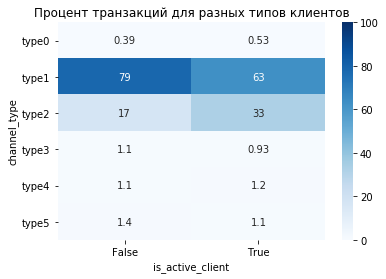

In [24]:
s = ds.pivot_table(index='channel_type', columns='is_active_client', values='cl_id', aggfunc='nunique')
s = s/s.sum()*100
sns.heatmap(s, cmap='Blues', vmin=0, vmax=100, annot=True)
plt.title('Процент транзакций для разных типов клиентов')
plt.yticks(rotation=0)
plt.show()

Если бы неактивные клиенты были зарплатными, то какая-то из ячеек левого столбца сильно бы выделялась. Но такого почти нет.

Все клиенты привлекались через 1 и 2 каналы. Разница лишь в том, что активные больше приходят через второй канал, а неактивные - через первый.

Может быть type1 - это и есть зарплатные клиенты? Правда тогда большинство клиентов банка получаются зарплатными.

Малый объём 0,3,4,5 каналов привлечения позволяют объединить их в одну группу

In [25]:
ds['channel_type_grouped'] = ds['channel_type'].apply(lambda x: x if x in ['type1','type2'] else 'other')

### currency

Валюта транзакции

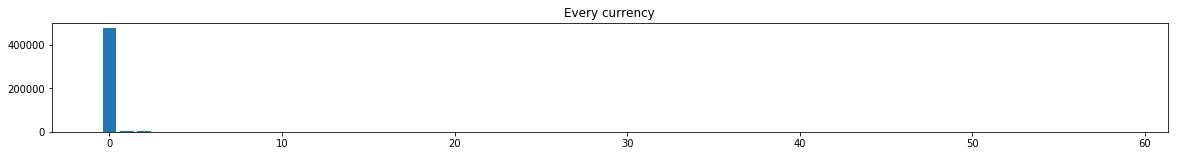

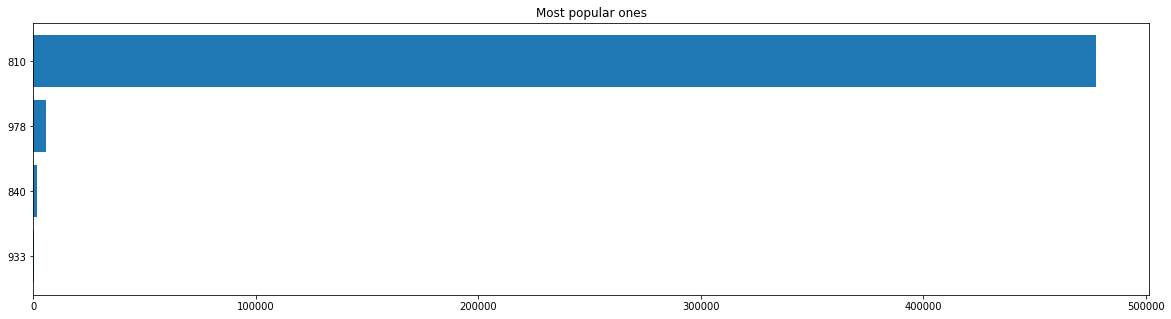

In [26]:
plt.figure(figsize=(20,2))
s = ds['currency'].value_counts()
#sns.distplot(s.values)
plt.bar(range(len(s)), s.values)
plt.title('Every currency')
plt.show()

plt.figure(figsize=(20,5))
s = s[s>s.sum()*0.001].sort_values(ascending=True)
plt.barh(range(len(s)), s.values)
plt.yticks(range(len(s)), s.index, rotation=0)#, fontsize=32)
plt.title('Most popular ones')
plt.show()

Почти все транзакции осуществлены в трёх валютах

Названия валют можно взять с сайта https://alpari.com/ru/beginner/articles/currency-codes/

In [27]:
crncy_map = {810:'RUB', 978:'EUR', 840:'USD', 933:'BYN'}
ds['currency_verb'] = ds['currency'].apply(lambda x: crncy_map.get(x,'NA'))

In [28]:
ds['currency_verb'].value_counts()/ds.shape[0]

RUB    0.973768
EUR    0.011286
NA     0.009890
USD    0.003912
BYN    0.001144
Name: currency_verb, dtype: float64

Курсы валют в качестве данных для датасета учитывать не будем, так как для этого пришлось бы загружать курсы всех валют. При этом абсолютное большинство транзакций все равно в рублях

### TRDATETIME

Дата транзакции

Вычленим из TRDATETIME информацию о дне, месяце и т.п.

In [29]:
ds['TRDATETIME_dt'] = pd.to_datetime(ds['TRDATETIME'], format='%d%b%y:%H:%M:%S')

In [30]:
ds['day'] = [x.day for x in ds['TRDATETIME_dt']]
ds['month'] = [x.month for x in ds['TRDATETIME_dt']]
ds['year'] = [x.year for x in ds['TRDATETIME_dt']]
ds['weekday'] = [x.weekday() for x in ds['TRDATETIME_dt']]

In [31]:
ds['hour'] = [x.hour for x in ds['TRDATETIME_dt']]

In [32]:
ds['is_holiday'] = (ds['weekday']>=5).astype(int)

In [33]:
ds['is_holiday'].value_counts()

0    354370
1    136141
Name: is_holiday, dtype: int64

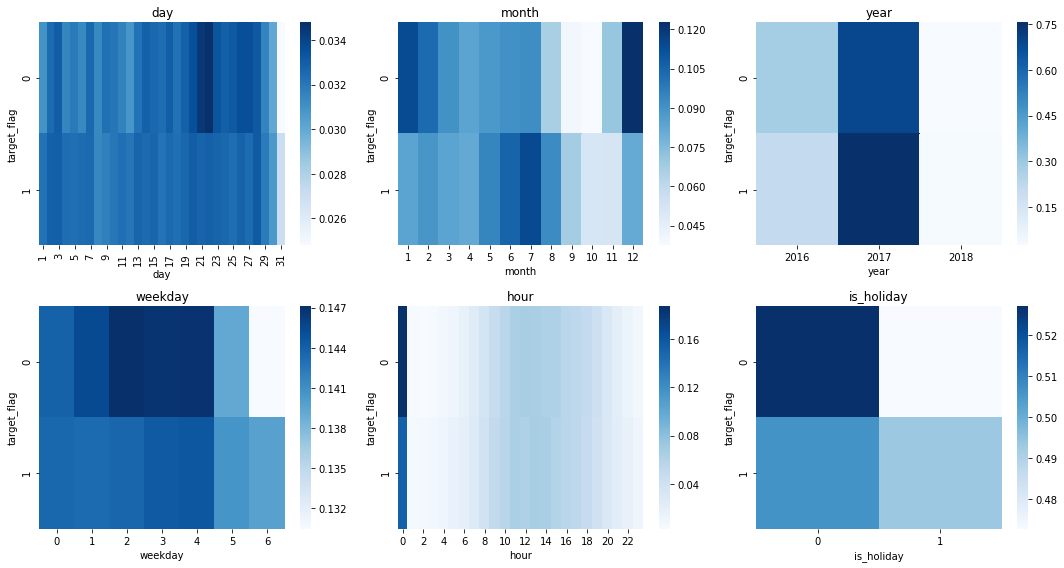

In [34]:
plt.figure(figsize=(15,8))
for idx, f in enumerate(['day','month','year','weekday','hour','is_holiday']):
    plt.subplot(2,3,idx+1)
    s = ds.pivot_table(index=f, columns='target_flag', values='cl_id', aggfunc='nunique')
    s = s/s.sum()
    sns.heatmap(s.T, cmap='Blues')
    plt.title(f)
plt.tight_layout()
plt.show()

Кажется нет никакой разницы между простыми признаками времени

Кажется, что клиент должен переставать пользоваться услугами банка постепенно. Т.е. его частота транзакций должна увеличиваться во времени.

Посмотрим как целевая переменная зависит от средней периодичности транзакций клиента

In [35]:
dss = []
for cl in tqdm_notebook(ds['cl_id'].drop_duplicates()):
    cds = ds[ds['cl_id']==cl].sort_values('TRDATETIME_dt')
    s = cds['TRDATETIME_dt']
    s = s-s.shift(1)
    s = [x.days for x in s]
    cds['days_since_last_trans'] = s
    dss.append(cds)
ds = pd.concat(dss)
ds['days_since_last_trans'] = ds['days_since_last_trans'].fillna(0)

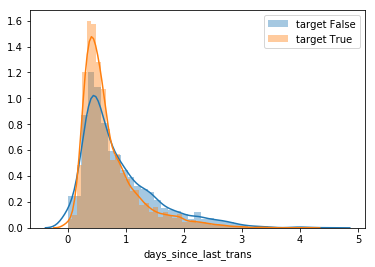

In [36]:
cds = ds.groupby('cl_id')[['days_since_last_trans','target_flag']].mean()
sns.distplot(np.log1p(cds[cds['target_flag']==0]['days_since_last_trans']), label='target False')
sns.distplot(np.log1p(cds[cds['target_flag']==1]['days_since_last_trans']), label='target True')
plt.legend()
plt.show()

Особой разницы в распределениях не видно

Можно посмотреть изменение периодичности транзакций во времени: как часто клиент совершил свои последние 1,2,3,...,10 транзакций относительно своей средней частоты

In [37]:
dss = []
for cl in tqdm_notebook(ds['cl_id'].drop_duplicates()):
    cds = ds[ds['cl_id']==cl].sort_values('TRDATETIME_dt')
    s = cds['days_since_last_trans']
    for i in range(1,11):
        cds[f'last_{i}_trans_freq'] = np.mean(s[-i:])
        cds[f'last_{i}_trans_coef'] = np.mean(s[-i:])/np.mean(s) if np.mean(s)!=0 else 0
    dss.append(cds)
ds = pd.concat(dss)

In [38]:
ds.loc[:,ds.drop('MCC_group',1).columns] = ds.drop('MCC_group',1).fillna(0)

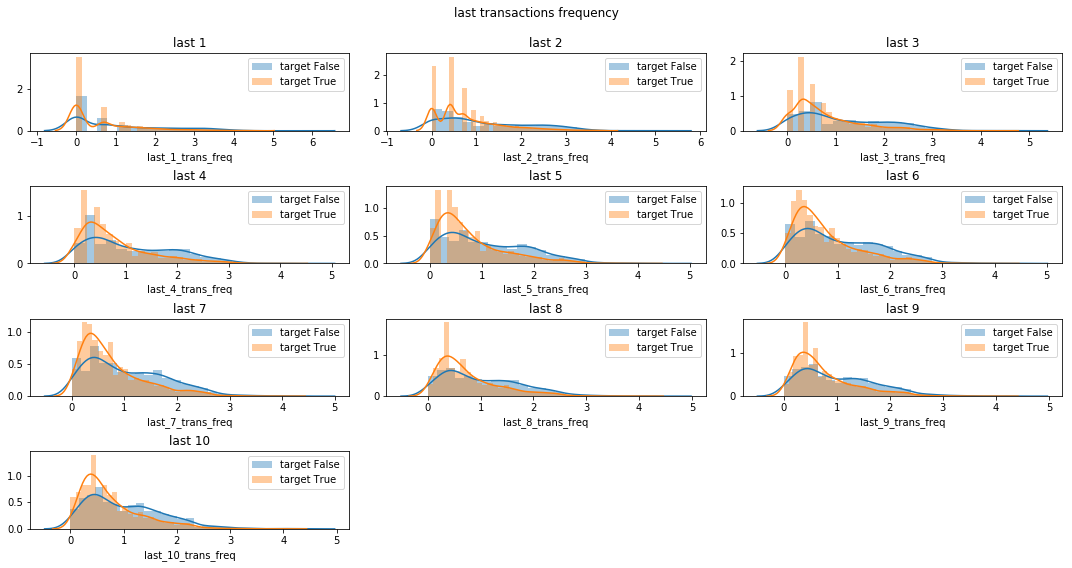

In [39]:
plt.figure(figsize=(15,8))
for i in range(1,11):
    plt.subplot(4,3,i)
    cds = ds.groupby('cl_id')[[f'last_{i}_trans_freq','target_flag']].mean()
    sns.distplot(np.log1p(cds[cds['target_flag']==0][f'last_{i}_trans_freq']), label='target False')
    sns.distplot(np.log1p(cds[cds['target_flag']==1][f'last_{i}_trans_freq']), label='target True')
    plt.title(f'last {i}')
    plt.legend()
plt.tight_layout()
plt.suptitle('last transactions frequency')
plt.subplots_adjust(top=0.9)
plt.show()

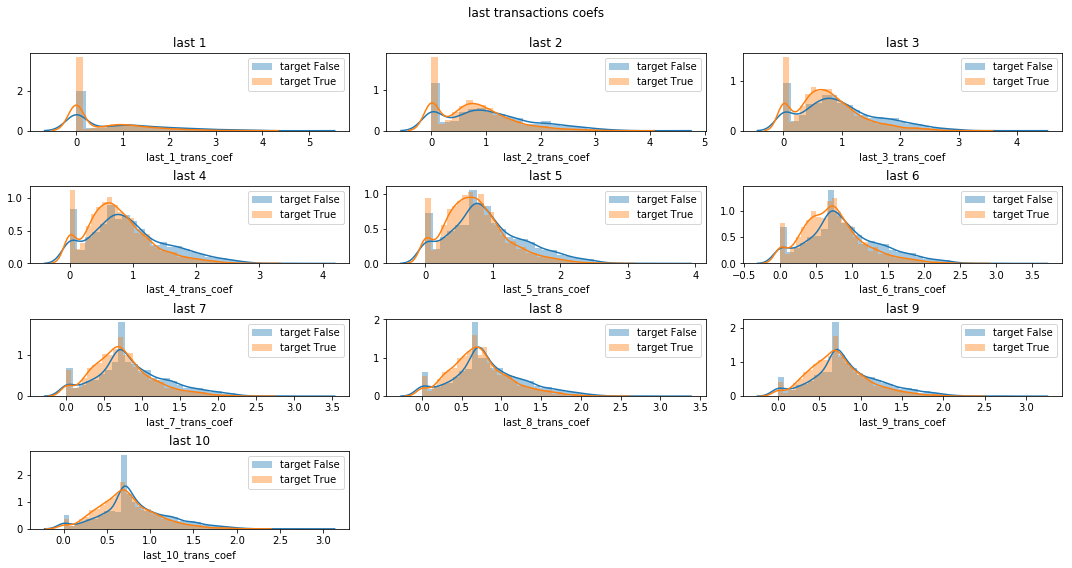

In [40]:
plt.figure(figsize=(15,8))
for i in range(1,11):
    plt.subplot(4,3,i)
    cds = ds.groupby('cl_id')[[f'last_{i}_trans_coef','target_flag']].mean()
    sns.distplot(np.log1p(cds[cds['target_flag']==0][f'last_{i}_trans_coef']), label='target False')
    sns.distplot(np.log1p(cds[cds['target_flag']==1][f'last_{i}_trans_coef']), label='target True')
    plt.title(f'last {i}')
    plt.legend()
plt.tight_layout()
plt.suptitle('last transactions coefs')
plt.subplots_adjust(top=0.9)
plt.show()

Наибольшее разделение кажется достигается при сравнении частоты последних 5 транзакций со всеми

In [41]:
собранныйcds = ds.groupby(['cl_id','day','month','year'])['TRDATETIME_dt'].count().to_frame()
cds.columns = ['n_transactions_per_date']
cds = cds.reset_index()

In [42]:
ds = pd.merge(ds, cds, on=['cl_id','day','month','year'])

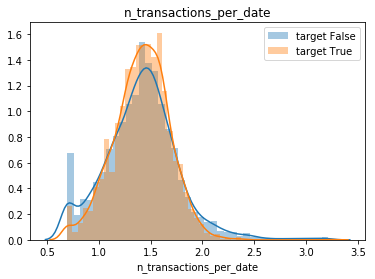

In [43]:
cds = ds.groupby('cl_id')[['n_transactions_per_date','target_flag']].mean()
sns.distplot(np.log1p(cds[cds['target_flag']==0]['n_transactions_per_date']), label='target False')
sns.distplot(np.log1p(cds[cds['target_flag']==1]['n_transactions_per_date']), label='target True')
plt.title('n_transactions_per_date')
plt.legend()

### amount

Объём транзакции

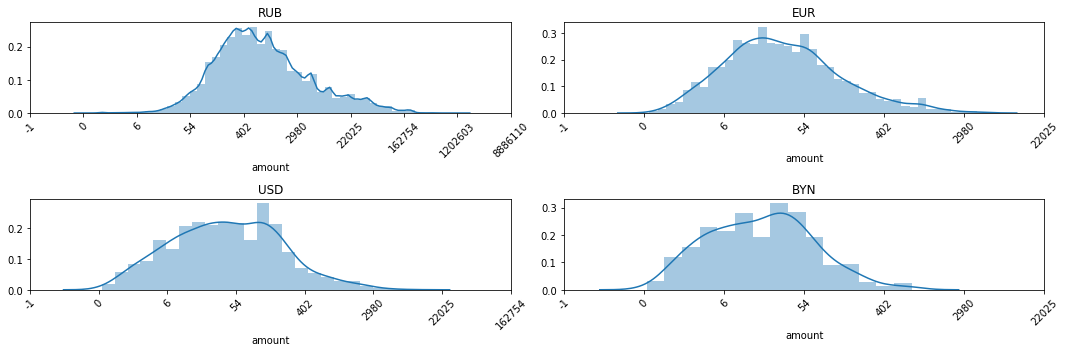

In [44]:
plt.figure(figsize=(15,5))
for idx, crncy in enumerate(crncy_map.keys()):
    plt.subplot(2,2,idx+1)
    sns.distplot(np.log1p(ds[ds['currency']==crncy]['amount']))
    plt.title(crncy_map[crncy])
    plt.xticks(plt.xticks()[0], np.expm1(plt.xticks()[0]).round(0).astype(int), rotation=45)
plt.tight_layout()
plt.show()

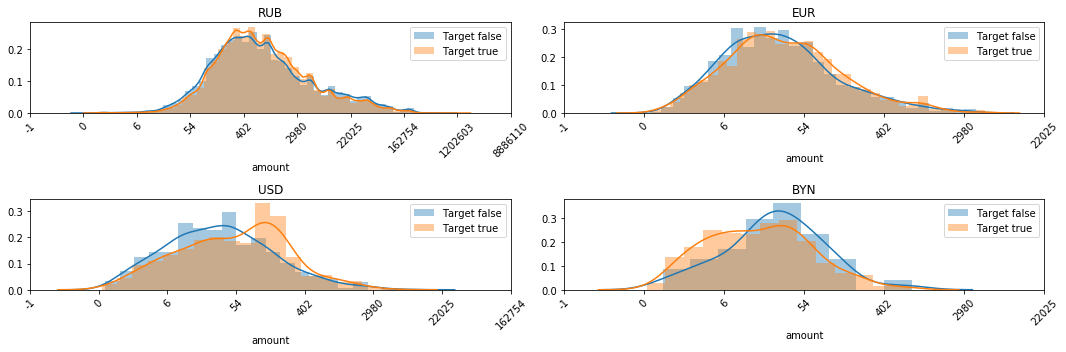

In [45]:
plt.figure(figsize=(15,5))
for idx, crncy in enumerate(crncy_map.keys()):
    plt.subplot(2,2,idx+1)
    cds = ds[ds['target_flag']==0]
    sns.distplot(np.log1p(cds[cds['currency']==crncy]['amount']), label='Target false')
    cds = ds[ds['target_flag']==1]
    sns.distplot(np.log1p(cds[cds['currency']==crncy]['amount']), label='Target true')
    plt.title(crncy_map[crncy])
    plt.xticks(plt.xticks()[0], np.expm1(plt.xticks()[0]).round(0).astype(int), rotation=45)
    plt.legend()
plt.tight_layout()
plt.show()

Интересное распределение в USD и BYN

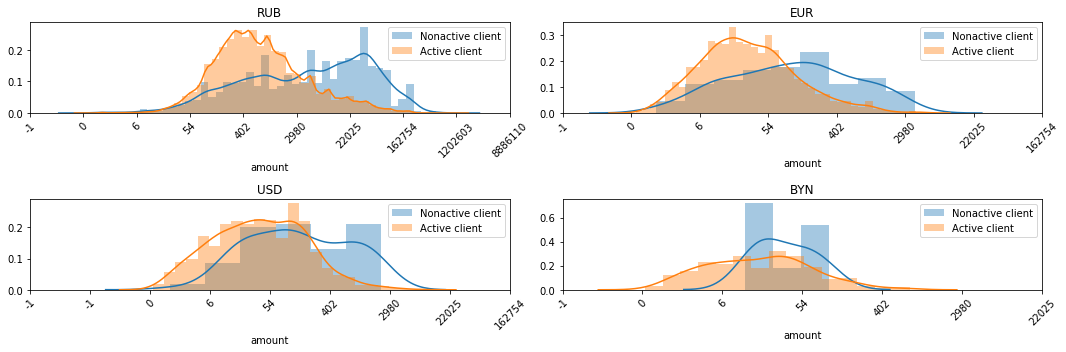

In [46]:
plt.figure(figsize=(15,5))
for idx, crncy in enumerate(crncy_map.keys()):
    plt.subplot(2,2,idx+1)
    cds = ds[ds['is_active_client']==0]
    sns.distplot(np.log1p(cds[cds['currency']==crncy]['amount']), label='Nonactive client')
    cds = ds[ds['is_active_client']==1]
    sns.distplot(np.log1p(cds[cds['currency']==crncy]['amount']), label='Active client')
    plt.title(crncy_map[crncy])
    plt.xticks(plt.xticks()[0], np.expm1(plt.xticks()[0]).round(0).astype(int), rotation=45)
    plt.legend()
plt.tight_layout()
plt.show()

Активные клиенты совершают транзакции меньшего объёма, но чаще. Вполне логично.

### trx_category

Категория транзакции

In [47]:
ds['trx_category'].value_counts()

POS               416423
DEPOSIT            21216
WD_ATM_ROS         19104
WD_ATM_PARTNER      9948
C2C_IN              7306
WD_ATM_OTHER        7140
C2C_OUT             5456
BACK_TRX            2687
CAT                 1197
CASH_ADV              34
Name: trx_category, dtype: int64

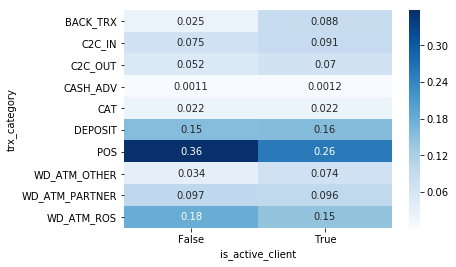

In [48]:
s = ds.pivot_table(index='trx_category',columns='is_active_client', values='cl_id', aggfunc='nunique')
s = s/s.sum()
sns.heatmap(s, cmap='Blues', annot=True)

### target_flag

Признак, продожит ли клиент пользоваться услугами банка

In [49]:
ds.groupby('cl_id')['target_flag'].mean().mean()

0.5534

Значение целевого признака сбалансировано. Это хорошо

### target_sum

Сумма чего-то?

In [50]:
ds.groupby('cl_id')['target_sum'].nunique().mean()

1.0

Значение уникально для каждого клиента

In [51]:
ds.groupby('target_flag')['target_sum'].sum()

target_flag
0    0.000000e+00
1    7.982339e+10
Name: target_sum, dtype: float64

Для клиентов с нулевым target_flag target_sum тоже равен нулю. Наверняка target_flag - это признак, напрямую произведённый из target_sum. Поэтому target_sum нельзя использовать при предсказании target_flag - иначе задача будет слишком просто

## Построение модели

In [52]:
test_clients = np.sort(np.random.choice(ds['cl_id'].drop_duplicates(), size=1000, replace=False))
train_clients = ds[-ds['cl_id'].isin(test_clients)]['cl_id'].drop_duplicates().sort_values().values

## Предсказание на исходных признаках

In [53]:
y_feat = 'target_flag'
real_feats = ['amount']
cat_feats = ['PERIOD','MCC_desc', 'channel_type', 'currency','trx_category']
bin_feats = [x for x in cat_feats if ds[x].nunique()<=2]
cat_feats = list(set(cat_feats)-set(bin_feats))

In [54]:
dss = []
for f in cat_feats:
    cds = ds.pivot_table(index='cl_id', columns=f, values='amount', aggfunc='mean', fill_value=0)
    cds.columns = [f+'__'+str(x) for x in cds.columns]
    dss.append(cds)
cds = pd.concat(dss,1)
for f in real_feats+bin_feats:
    cds[f] = ds.groupby('cl_id')[f].mean()
cds['target_flag'] = ds.groupby('cl_id')['target_flag'].mean()

In [55]:
X,Y = cds.drop(y_feat,1), cds[y_feat]

idx = X.index.isin(train_clients)
X_train, Y_train = X[idx], Y[idx]

idx = X.index.isin(test_clients)
X_test, Y_test = X[idx], Y[idx]

In [56]:
xgb = XGBClassifier()
xgb.fit(X_train, Y_train)
preds = xgb.predict_proba(X_test)[:,1]

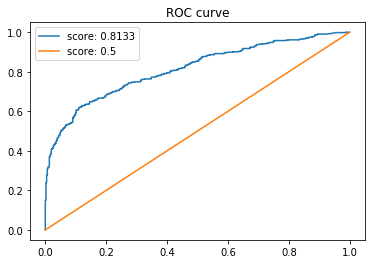

In [57]:
score = roc_auc_score(Y_test, preds)
fprs, tprs, treshs = roc_curve(Y_test, preds)
plt.plot(fprs, tprs, label=f'score: {score:.4f}')
plt.plot([0,1],[0,1], label='score: 0.5')
plt.title(f'ROC curve')
plt.legend()
plt.show()

In [58]:
feat_imps = pd.Series(xgb.feature_importances_, index=X_train.columns)
feat_imps =  feat_imps[feat_imps>0]
feat_imps = feat_imps[feat_imps>0.01*feat_imps.sum()].sort_values(ascending=False)

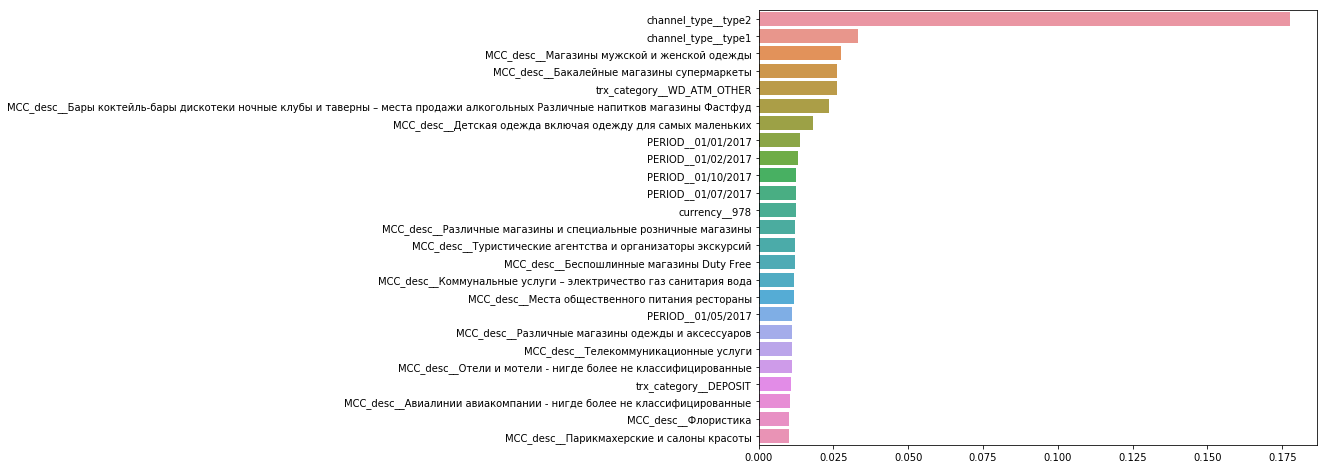

In [59]:
plt.figure(figsize=(10,8))
sns.barplot(y=feat_imps.index, x=feat_imps.values)
plt.show()

## Предсказание на новых признаках

In [60]:
y_feat = 'target_flag'
real_feats = ['amount','days_since_last_trans','n_transactions_per_date',
              #  'last_1_trans_freq', 'last_1_trans_coef',
              #    'last_2_trans_freq', 'last_2_trans_coef',
              #'last_3_trans_freq', 'last_3_trans_coef',
              #  'last_4_trans_freq', 'last_4_trans_coef',
              'last_5_trans_freq','last_5_trans_coef',
              #'last_6_trans_freq', 'last_6_trans_coef',
              #'last_7_trans_freq', 'last_7_trans_coef',
              #'last_8_trans_freq', 'last_8_trans_coef',
              #'last_9_trans_freq', 'last_9_trans_coef',
              #  'last_10_trans_freq', 'last_10_trans_coef'
             ]
cat_feats = ['MCC_grouped', 'MCC_group','currency_verb','channel_type_grouped','trx_category','is_active_client',
            'hour',
             'day',
             'month','weekday','is_holiday', 'PERIOD'
            ]
bin_feats = [x for x in cat_feats if ds[x].nunique()<=2]
cat_feats = list(set(cat_feats)-set(bin_feats))

In [61]:
dss = []
for f in cat_feats:
    cds = ds.pivot_table(index='cl_id', columns=f, values='amount', aggfunc='mean', fill_value=0)
    cds.columns = [f+'__'+str(x) for x in cds.columns]
    dss.append(cds)
cds = pd.concat(dss,1)
for f in real_feats+bin_feats:
    cds[f] = ds.groupby('cl_id')[f].mean()
cds['target_flag'] = ds.groupby('cl_id')['target_flag'].mean()

In [62]:
X,Y = cds.drop(y_feat,1), cds[y_feat]

idx = X.index.isin(train_clients)
X_train, Y_train = X[idx], Y[idx]

idx = X.index.isin(test_clients)
X_test, Y_test = X[idx], Y[idx]

In [63]:
xgb = XGBClassifier()
xgb.fit(X_train, Y_train)
preds = xgb.predict_proba(X_test)[:,1]

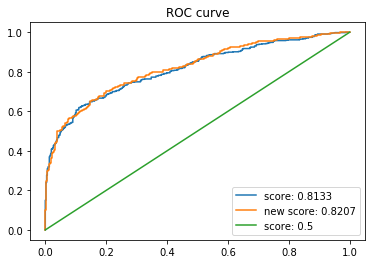

In [64]:
score_new = roc_auc_score(Y_test, preds)
fprs_new, tprs_new, treshs_new = roc_curve(Y_test, preds)
plt.plot(fprs, tprs, label=f'score: {score:.4f}')
plt.plot(fprs_new, tprs_new, label=f'new score: {score_new:.4f}')
plt.plot([0,1],[0,1], label='score: 0.5')
plt.title(f'ROC curve')
plt.legend()
plt.show()

In [65]:
feat_imps = pd.Series(xgb.feature_importances_, index=X_train.columns)
feat_imps = feat_imps[feat_imps>0]
feat_imps = feat_imps[feat_imps>0.01*feat_imps.sum()].sort_values(ascending=False)

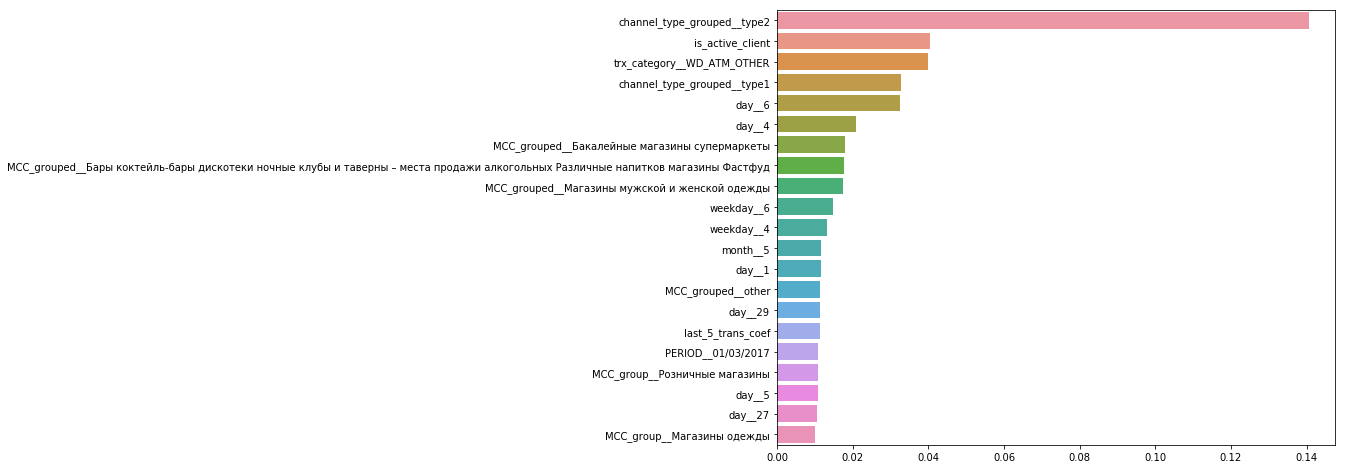

In [66]:
plt.figure(figsize=(10,8))
sns.barplot(y=feat_imps.index, x=feat_imps.values)
plt.show()

# Вывод

Качество работы алгоритма с новыми данными чуть лучше, чем с исходными.

* Признак is_active_client оказался топ5.
* Модель очень сильно ориентируется на продажи за день. Это подозрительно. Хотя это может быть связано с днями выплаты зарплат.